<img src="https://github.com/aniacharya/MachineLearning/blob/master/images/DXC.png?raw=true" width="240" height="360" />

# AGENT CHURN ANALYSIS - Base Model using Logistic Regression

**Problem Statement**

Predicting Insurance Agent Attrition. Identifying those agents most likely to switching to another company.

- Visualize the relationship between the features and the churn using  plots.
- We want to find a function that given explanatory variables predicts the churn for an agent.

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# Get Current time
import datetime 

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

# For Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For Feature Selection
from sklearn.feature_selection import chi2, SelectKBest

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

#to ignore the warning messages from being printed
import warnings
warnings.filterwarnings('ignore')

C:\Users\aaacharya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# Import Dataset
# Explicitly setting data type for columns which are string data type  

df_orig = pd.read_csv('agent_churn.csv')

In [3]:
# Check data sample
df_orig.head()

,Agent Number,Date_of_Appointment,Date_of_Termination,Commission Class,Pay Method,Pay Frequency,Agent Type,Agent Branch Code,Agent Reporting Level,Agent Date of Birth,Agent Gender,Number_of_Policies,Number_of_Claims,Total_Claim_Amount,Total_Payment_Amount,Total_Commission_Amount,Churn
0,50001187,20150526,NaN,3,DC,12,AM,10,1,19910507.0,M,5,0,0.0,0.0,0.0,0
1,50002503,20151214,NaN,3,CQ,12,AG,10,1,19830404.0,M,4,0,0.0,0.0,0.0,0
2,50004847,20200101,NaN,3,CQ,12,BR,10,1,19800101.0,M,0,0,0.0,0.0,0.0,0
3,50040992,20230104,NaN,3,CQ,12,AG,10,1,19750101.0,M,1,0,0.0,0.0,0.0,0
4,50041143,20230101,NaN,2,CQ,12,AM,10,1,19880101.0,M,0,0,0.0,0.0,0.0,0


## Data Analysis

In [4]:
# Check data shape
df_orig.shape

(3631, 17)

In [5]:
# Check if there are any nulls
df_orig.isnull().sum()

Agent Number                  0
Date_of_Appointment           0
Date_of_Termination        3619
Commission Class              0
Pay Method                    0
Pay Frequency                 0
Agent Type                    0
Agent Branch Code             0
Agent Reporting Level         0
Agent Date of Birth          32
Agent Gender                  0
Number_of_Policies            0
Number_of_Claims              0
Total_Claim_Amount            0
Total_Payment_Amount          0
Total_Commission_Amount       0
Churn                         0
dtype: int64

In [6]:
# Check data attributes of the columns
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 17 columns):
Agent Number               3631 non-null int64
Date_of_Appointment        3631 non-null int64
Date_of_Termination        12 non-null float64
Commission Class           3631 non-null int64
Pay Method                 3631 non-null object
Pay Frequency              3631 non-null int64
Agent Type                 3631 non-null object
Agent Branch Code          3631 non-null int64
Agent Reporting Level      3631 non-null int64
Agent Date of Birth        3599 non-null float64
Agent Gender               3631 non-null object
Number_of_Policies         3631 non-null int64
Number_of_Claims           3631 non-null int64
Total_Claim_Amount         3631 non-null float64
Total_Payment_Amount       3631 non-null float64
Total_Commission_Amount    3631 non-null float64
Churn                      3631 non-null int64
dtypes: float64(5), int64(9), object(3)
memory usage: 482.3+ KB


### Need to change data types of few columns, will do so in data processing section

In [7]:
# View distribution of 'Lapse' Instances
df_orig['Churn'].value_counts()

0    3619
1      12
Name: Churn, dtype: int64

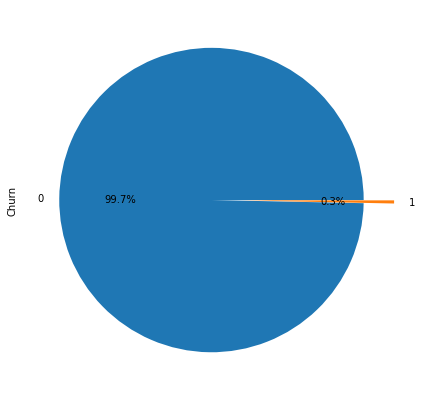

In [8]:
f,ax = plt.subplots(1,1,figsize=(22,7))
df_orig['Churn'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%')

### Data is highly imbalanced, need to take this in scope

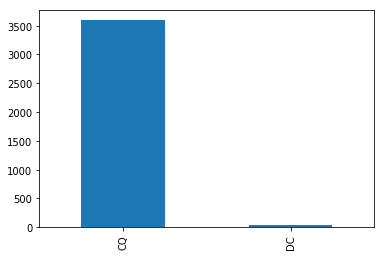

In [9]:
df_orig['Pay Method'].value_counts().sort_index().plot.bar()

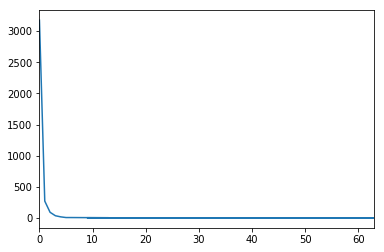

In [10]:
df_orig['Number_of_Claims'].value_counts().plot.line()

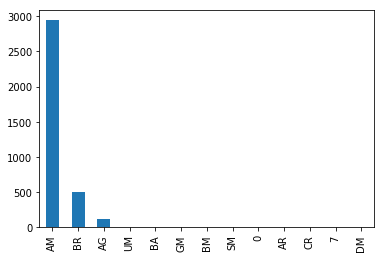

In [11]:
df_orig['Agent Type'].value_counts().plot.bar()

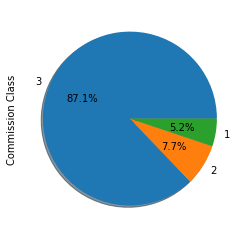

In [12]:
df_orig['Commission Class'].value_counts().plot.pie(explode=[0,0,0],autopct='%1.1f%%',shadow=True)

## Data Treatment

In [13]:
# Create a copy of dataframe
df_work = df_orig.copy()

In [14]:
# Separate features into categorical and numerical category
cat_vars = ['Commission Class','Pay Method','Pay Frequency','Agent Type','Agent Branch Code',
            'Agent Reporting Level','Agent Gender']

num_vars = ['Number_of_Policies', 'Number_of_Claims', 'Total_Claim_Amount','Total_Payment_Amount','Total_Commission_Amount']

date_vars = ['Date_of_Appointment', 'Date_of_Termination', 'Agent Date of Birth' ]

In [15]:
# Convert date columns

for var in date_vars:
    #df_work[var] = df_work[var].astype('category')
    #df_work[var] = datetime.datetime.strptime(var, '%Y-%m-%d')
    df_work[var]=pd.to_datetime(df_work[var].astype(str), format='%Y%m%d')

In [16]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [17]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [18]:
# Check data shape after dummy encoding
df_work.shape

(3631, 42)

In [19]:
# Remove original columns for which dummy variables have been created
vars_remove = ['Commission Class','Pay Method','Pay Frequency','Agent Type','Agent Branch Code',
            'Agent Reporting Level','Agent Gender']

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [20]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['Number_of_Policies'] = scaler.fit_transform(df_work['Number_of_Policies'].values.reshape(-1,1))
df_work['Number_of_Claims'] = scaler.fit_transform(df_work['Number_of_Claims'].values.reshape(-1,1))
df_work['Total_Claim_Amount'] = scaler.fit_transform(df_work['Total_Claim_Amount'].values.reshape(-1,1))
df_work['Total_Payment_Amount'] = scaler.fit_transform(df_work['Total_Payment_Amount'].values.reshape(-1,1))
df_work['Total_Commission_Amount'] = scaler.fit_transform(df_work['Total_Commission_Amount'].values.reshape(-1,1))

### Feature Engineering

In [21]:
# Get current date
current_time = datetime.datetime.now() 

In [22]:
# Create a new column 'Age' on the basis of date of birth of agent
df_work['age'] = current_time - df_work['Agent Date of Birth']

In [23]:
# Create a new column named 'service period' on the basis of difference between Agent Date of Registration and Termination.
# In case date of Termination is null we will replace it with current date and compute

service_period=[]

for Date_of_Termination,Date_of_Appointment in zip(df_work.iloc[:,2], df_work.iloc[:,1]):
    if Date_of_Termination is pd.NaT:
        service_period.append(abs(current_time-Date_of_Appointment))
    else:
        service_period.append(abs(Date_of_Termination-Date_of_Appointment))
    #print(Date_of_Termination)
    #print(Date_of_Appointment)


In [24]:
# Append the new column to dataframe
df_work['Service_Period']=service_period

# Remove the orginal columns
df_work=df_work.drop('Date_of_Appointment', axis=1)
df_work=df_work.drop('Date_of_Termination', axis=1)
df_work=df_work.drop('Agent Date of Birth', axis=1)

# Remove Agent Number since it is not critical for prediction
df_work=df_work.drop('Agent Number', axis=1)

In [25]:
# Check contents once
df_work.head()

,Number_of_Policies,Number_of_Claims,Total_Claim_Amount,Total_Payment_Amount,Total_Commission_Amount,Churn,Commission Class_1,Commission Class_2,Commission Class_3,Pay Method_CQ,Pay Method_DC,Pay Frequency_12,Agent Type_0,Agent Type_7,Agent Type_AG,Agent Type_AM,Agent Type_AR,Agent Type_BA,Agent Type_BM,Agent Type_BR,Agent Type_CR,Agent Type_DM,Agent Type_GM,Agent Type_SM,Agent Type_UM,Agent Branch Code_10,Agent Reporting Level_1,Agent Reporting Level_2,Agent Gender_,Agent Gender_F,Agent Gender_M,age,Service_Period
0,0.004476,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,10588 days 23:36:09.649113,1803 days 23:36:09.649113
1,0.003581,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,13543 days 23:36:09.649113,1601 days 23:36:09.649113
2,0.000000,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,14732 days 23:36:09.649113,122 days 23:36:09.649113
3,0.000895,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,16558 days 23:36:09.649113,976 days 00:23:50.350887
4,0.000000,0.0,0.0,0.0,0.0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,11810 days 23:36:09.649113,973 days 00:23:50.350887


In [26]:
# Check info
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3631 entries, 0 to 3630
Data columns (total 33 columns):
Number_of_Policies         3631 non-null float64
Number_of_Claims           3631 non-null float64
Total_Claim_Amount         3631 non-null float64
Total_Payment_Amount       3631 non-null float64
Total_Commission_Amount    3631 non-null float64
Churn                      3631 non-null int64
Commission Class_1         3631 non-null uint8
Commission Class_2         3631 non-null uint8
Commission Class_3         3631 non-null uint8
Pay Method_CQ              3631 non-null uint8
Pay Method_DC              3631 non-null uint8
Pay Frequency_12           3631 non-null uint8
Agent Type_0               3631 non-null uint8
Agent Type_7               3631 non-null uint8
Agent Type_AG              3631 non-null uint8
Agent Type_AM              3631 non-null uint8
Agent Type_AR              3631 non-null uint8
Agent Type_BA              3631 non-null uint8
Agent Type_BM              3631 non-n

In [27]:
# Normalize the new columns 
scaler = MinMaxScaler()
df_work['age'] = scaler.fit_transform(df_work['age'].values.reshape(-1,1))
df_work['Service_Period'] = scaler.fit_transform(df_work['Service_Period'].values.reshape(-1,1))

In [43]:
df_work.head()

,Number_of_Policies,Number_of_Claims,Total_Claim_Amount,Total_Payment_Amount,Total_Commission_Amount,Churn,Commission Class_1,Commission Class_2,Commission Class_3,Pay Method_CQ,Pay Method_DC,Pay Frequency_12,Agent Type_0,Agent Type_7,Agent Type_AG,Agent Type_AM,Agent Type_AR,Agent Type_BA,Agent Type_BM,Agent Type_BR,Agent Type_CR,Agent Type_DM,Agent Type_GM,Agent Type_SM,Agent Type_UM,Agent Branch Code_10,Agent Reporting Level_1,Agent Reporting Level_2,Agent Gender_,Agent Gender_F,Agent Gender_M,age,Service_Period
0,0.004476,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0.778619,0.174298
1,0.003581,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0.798227,0.154781
2,0.000000,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0.806117,0.011882
3,0.000895,0.0,0.0,0.0,0.0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0.818233,0.094301
4,0.000000,0.0,0.0,0.0,0.0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0.786728,0.094011


In [28]:
# Create separate dataset for feature and target columns
x = df_work.drop('Churn', axis=1)
y = df_work['Churn']

### Feature Selection

In [29]:
bestfeatures=SelectKBest(score_func=chi2, k=10)
fit=bestfeatures.fit(x,y)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x.columns)
#concatenate two dataframes
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features


                      Specs       Score
4   Total_Commission_Amount  179.461095
0        Number_of_Policies   79.038735
1          Number_of_Claims   51.598942
17            Agent Type_BM   35.968226
13            Agent Type_AG   16.425783
2        Total_Claim_Amount   11.655611
31           Service_Period    3.303779
14            Agent Type_AM    1.430251
6        Commission Class_2    1.252122
27           Agent Gender_     0.666482


In [30]:
# Get top features
top_features = ['Total_Commission_Amount', 'Number_of_Policies', 'Number_of_Claims','Agent Type_BM',
               'Agent Type_AG', 'Total_Claim_Amount', 'Service_Period', 'Agent Type_AM', 'Commission Class_2', 
               'Agent Gender_ ',]

In [31]:
# Create new dataset with only top features
x01=x[top_features]
y01=y

In [32]:
# Perform Test/Train Split
x01_train, x01_test, y01_train, y01_test=train_test_split(x01, y01, test_size=0.3,random_state=11)
x01_train.shape, x01_test.shape, y01_train.shape, y01_test.shape

((2541, 10), (1090, 10), (2541,), (1090,))

In [33]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

#X4_train, X4_test, Y4_train, Y4_test = train_test_split(X_train,Y_train, test_size=0.20)
x01_train_smo,y01_train_smo = SMO.fit_sample(x01_train, y01_train)
columns = x01_train.columns

x01_train_smo = pd.DataFrame(data = x01_train_smo, columns = columns )
y01_train_smo = pd.DataFrame(data = y01_train_smo, columns = ['Churn'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x01_train_smo))
print("Number of Churned agents in oversampled data",len(y01_train_smo[y01_train_smo['Churn']== 0 ]))
print("Number of Non Churned agents in oversampled data",len(y01_train_smo[y01_train_smo['Churn']== 1 ]))
print("Proportion of Non Churned agents in oversampled data is ",len(y01_train_smo[y01_train_smo['Churn']== 0])/len(x01_train_smo))
print("Proportion of Churned Agents in oversampled data is ",len(y01_train_smo[y01_train_smo['Churn']== 1 ])/len(x01_train_smo))

length of oversampled data is  5062
Number of Churned agents in oversampled data 2531
Number of Non Churned agents in oversampled data 2531
Proportion of Non Churned agents in oversampled data is  0.5
Proportion of Churned Agents in oversampled data is  0.5


## Model Application

### Logistic Regression with StratifiedKFold with set of weights provided.  Also use Gridsearch to obtain optimal parameters. 

In [34]:
# Define grid
C = np.logspace(0,5,10)
param_grid = dict( C=C)

# Model
logreg=LogisticRegression(solver='lbfgs',max_iter=1000)

# Define Evaluation Procedure
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=11)

# Define Grid Search
grid=GridSearchCV(estimator=logreg, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Execute Grid Search
grid_result=grid.fit(x01_train_smo, (y01_train_smo.values.ravel()))

In [35]:
# Print best model parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.972944 using {'C': 46.4158883361278}


In [36]:
bestlogreg = grid_result.best_estimator_
bestlogreg

LogisticRegression(C=46.4158883361278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
# Fit the model on train data
bestlogreg.fit(x01_train_smo, y01_train_smo)

LogisticRegression(C=46.4158883361278, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
# Make Predictions
y01_pred=bestlogreg.predict(x01_test)

In [39]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y01_test, y01_pred)
cnf_matrix  

array([[1026,   62],
       [   2,    0]], dtype=int64)

In [40]:
# Get Accuracy Scores
print("Accuracy:",metrics.accuracy_score(y01_test, y01_pred))
print("Precision:",metrics.precision_score(y01_test, y01_pred))
print("Recall:",metrics.recall_score(y01_test, y01_pred))

Accuracy: 0.9412844036697248
Precision: 0.0
Recall: 0.0


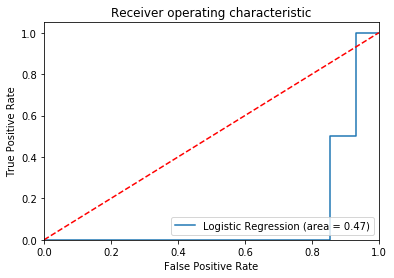

In [41]:
# Print ROC AUC Curve

logit_roc_auc = roc_auc_score(y01_test, bestlogreg.predict(x01_test))
fpr, tpr, thresholds = roc_curve(y01_test, bestlogreg.predict_proba(x01_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Save the model as PMML File

In [42]:
# Save the model as a pmml and use to make predictions in a file 

joblib.dump(bestlogreg, 'LifeAgentChurnModel.pmml') 

['LifeAgentChurnModel.pmml']